## Install Libraries

In [1]:
!pip install -q pycaret

In [2]:
!pip install -q fasttext

## 1.Import Dependencies

In [44]:
# -- data loading --
import pandas as pd
import numpy as np

# -- visualization --
import matplotlib.pyplot as plt
import seaborn as sns

# -- embeddings --
from sklearn.feature_extraction.text import TfidfVectorizer

# --- ml models ---
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier


# -- model evaluation --
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report

# -- utility --
from prettytable import PrettyTable
from tqdm import tqdm
import warnings
import mlflow
import os
os.getcwd()
warnings.filterwarnings('ignore')

In [1]:
import re
import os
import random
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import fasttext.util

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# regression
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
# naive bayes
from sklearn.naive_bayes import MultinomialNB
# support vector
from sklearn.svm import SVC
# decision tree
from sklearn.tree import DecisionTreeClassifier
# ensemble
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
# from catboost import CatBoostClassifier

# k neighbour
from sklearn.neighbors import KNeighborsClassifier

# stats
import statsmodels.api as sm
from scipy.stats import boxcox # this can't handle negative values
from scipy.stats import yeojohnson # this ia extention to boxcox

# encoder and scaling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer

from sklearn.model_selection import StratifiedKFold, cross_val_score

from pycaret.classification import *

## 2.Utility Functions

In [2]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

reference:

0 : business
1 : tech
2 : politics
3 : sport
4 : entertainment

In [3]:
from typing import List

label_dict = {
    0 : "business",
    1 : "tech",
    2 : "politics",
    3 : "sport",
    4 : "entertainment"
}

In [4]:
def index_to_label(y: List, label_dict: dict()):
  """
  this function converts the index to proper categorical labels

  y: [0, 1, 2, 3, 4]

  returns: ['business', 'tech', 'politics', 'sport', 'entertainment']
  """
  try:
    return list(map(lambda x: label_dict[x], y))
  except Exception as e:
    print(f"Error: {e}")


def label_to_index(y: List, label_dict: dict()):
  """
  this function converts the index to proper categorical labels
  """
  try:
    swapped_dict = {v: k for k, v in label_dict.items()}
    return list(map(lambda x: swapped_dict[x], y))
  except Exception as e:
    print(f"Error: {e}")

In [5]:
def confusion_matrix_and_roc_curve_plot(true: List, predicted: List, probabilities: List, label_dict: dict()):
  """
  this function plots confusion matrix and Roc curev for model
  """
  try:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # -------- Confusion matrix plot --------
    cm = confusion_matrix(true, predicted)

    # Heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.values(), yticklabels=label_dict.values(), ax=axes[0])

    # Labels and title
    axes[0].set_xlabel('Predicted Labels')
    axes[0].set_ylabel('True Labels')
    axes[0].set_title(f'Confusion Matrix\nF1 Score (weighted): {f1_score(true, predicted, average="weighted")}')


    # -------- ROC Curve --------
        # Binarize the output
    y = label_binarize(true, classes=[i for i in range(len(label_dict.keys()))])
    n_classes = y.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw= 2
    # Plot all ROC curves
    axes[1].plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    axes[1].plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "blue"])
    for i, color in zip(range(n_classes), colors):
        axes[1].plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class: {0} (area = {1:0.2f})".format( label_dict[i], roc_auc[i]),
        )

    axes[1].plot([0, 1], [0, 1], "k--", lw=lw)
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title("Receiver operating characteristic to multiclass")
    axes[1].legend(loc="lower right")

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

  except Exception as e:
    print(f"Error: {e}")

In [6]:
def context_length_wise_precision(df: pd.DataFrame, predictions: List, bins:int = 100):
  """
    this function categorizes text based on token lengths of text, then
    compares the context length bins bar vs model precision, using this
    plot we can under stand models context understanding power.

    Args:
      bins (int) : size of each bin
  """
  try:
    # bins = 100 # size of a bins
    min = 0
    max = df["token_length"].max()

    # bin labels (x-axis)
    categories = [i for i in range(bins, max+bins, bins)]
    # adding predictions to dataframe
    df["pred"] = predictions

    # calculating bin frequency and true positive count
    actual_freq = []
    true_positive_for_bin = []

    # Get the unique classes in y_true
    classes = df['Label'].unique()

    for i in range(min, max, bins):
      dummy_df = df[(df["token_length"] > i) & (df["token_length"] <= i+bins)].copy()
      # collecting count for bin
      actual_freq.append(dummy_df.shape[0])
      # Loop through each class and calculate True Positives (TP) count
      TP = 0
      for cls in classes:
          TP += len(dummy_df[(dummy_df['Label'] == cls) & (dummy_df['pred'] == cls)])
      true_positive_for_bin.append(TP)

    # Set the position of the bars on the x-axis
    x = np.arange(len(categories))  # The x locations for the groups
    width = 0.3  # Bar width

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bars for the first dataset
    ax.bar(x - width/2, actual_freq, width, label='Actual', color='blue')

    # Plot the bars for the second dataset
    ax.bar(x + width/2, true_positive_for_bin, width, label='Predictions', color='green')

    # Labeling
    ax.set_xlabel('Categories of Bins')
    ax.set_ylabel('Values')
    ax.set_title('Comparison Bar Plot')
    ax.set_xticks(x)  # Set x-ticks to the center of the groups
    ax.set_xticklabels(categories)  # Set x-tick labels
    ax.legend()
    ax.grid()
    # Show the plot
    plt.tight_layout()
    plt.show()

  except Exception as e:
    print(f"Error: {e}")

In [16]:
class Model_Selection_Methods:

  def __init__(self, X_train, y_train, X_test, y_test, CV, scoring, shuffle, seed = 42):
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.cv = CV
    self.scoring = scoring
    self.shuffle = shuffle
    self.seed = seed
    self.model_tags = ["LR", "RDG", "NB", "SVM", "KNN", "DT", "RF", "SGD", "GB", "AB", "ETC", "XGB", "XGRFB", "LGB", "CB"]
    self.rfe_model_tags = ["LR", "RDG", "SGD", "DT" , "RF", "ETC", "GB", "SVM", "XGB", "XGRFB", "CB" ]
    self.scaler_tags = ["Normal_l1", "Normal_l2", "MaxAbcScaler", "Robust", "MinMax", "Standard"]

  def get_model(self, model_tag):
    """ loads different models"""
    if model_tag == "LR":
        return {"LR": ("Logistic Regression", LogisticRegression(solver="liblinear" ,max_iter=2000))}

    if model_tag == "RDG":
        return {"RDG": {"Ridge Classifier", RidgeClassifier()}}

    if model_tag == "SGD":
        return {"SGD": ("Stocastic Gradient", SGDClassifier())}

    if model_tag == "NB":
        return {"NB": ("Naive Bayes", MultinomialNB())}

    if model_tag == "SVM":
        return {"SVM": ("Support Vector", SVC(kernel='linear'))} # this kernel works with RFE

    if model_tag == "KNN":
        return {"KNN": ("K-Neighbors", KNeighborsClassifier(n_neighbors=2))}

    if model_tag == "DT":
        return {"DT": ("Decision Tree", DecisionTreeClassifier())}

    if model_tag == "RF":
        return {"RF": ("Random Forest", RandomForestClassifier())}

    if model_tag == "GB":
        return {"GB": ("Gradient Boosting", GradientBoostingClassifier())}

    if model_tag == "AB":
        return {"AB": ("Ada Boosting", AdaBoostClassifier())}

    if model_tag == "ETC":
        return {"ETC": ("Extra Tres Boosting", ExtraTreesClassifier())}

    if model_tag == "XGB":
        return {"XGB": ("Extra Gradient Boosting", XGBClassifier())}

    if model_tag == "XGRFB":
        return {"XGRFB": ("Extra Random Forest Boosting", XGBRFClassifier())}

    if model_tag == "LGB":
        return {"LGB": ("Light Boosting",LGBMClassifier(learning_rate=0.01, n_estimators=1000))}

    # if model_tag == "CB":
    #     return {"CB": ("Cat Boosting", CatBoostClassifier(verbose=0))}

  def get_scaler(self, type_of_scale:str):
    """
    Objective:

    this function return scalar object

    Parameters:

    type_of_scale (str): choose type of scaler function

    Returns:

    sklearn.preprocessing.scaler : scaling object
    """
    if type_of_scale == "Normal_l1":
        scaler = Normalizer(norm='l1')
        return scaler

    elif type_of_scale == "Normal_l2":
        scaler = Normalizer(norm='l2')
        return scaler

    elif type_of_scale == "MaxAbcScaler":
        scaler = MaxAbsScaler()
        return scaler

    elif type_of_scale == "Robust":
        scaler = RobustScaler()
        return scaler

    elif type_of_scale == "MinMax":
        scaler = MinMaxScaler()
        return scaler

    elif type_of_scale == "Standard":
        scaler = StandardScaler()
        return scaler

  def evaluate_model(self, X, y, model):
    # define the model evaluation procedure
    cv = StratifiedKFold(n_splits=self.cv, random_state=self.seed, shuffle=self.shuffle)

    # evaluate the model: n-jobs=-1 [uses all cores]
    scores = cross_val_score(model, X, y, scoring=self.scoring, cv=cv, n_jobs=-1)

    return scores


  def model_selection(self, model_tags:List[str], scaler_tags:List[str], print_status:bool = False):
      """
      Objective:

      |          models       | standard_scaling | standard_scaling | scaling 2 | ... | scaling 4 |
      ---------------------------------------------------------------------------------------------
      |   logistic regression |         f1       |         f1       |     f1    | ... |   f1    |
      |   ridge regression    |         f1       |         f1       |     f1    | ... |   f1    |
      |   decision tree       |         f1       |         f1       |     f1    | ... |   f1    |

      Parameters:

      model_tags (list[str]) : chosen models tags

      scaler_tags (list[str]) : choose scaler tags

      single_model (bool) : while running for single model only

      print_status (bool): print model training status

      Returns:

      model_report (dict): models performance on each combination (model X scaler)
      """
      # run model evaluation for all combination possible
      model_report = dict()

      for scaler_tag in scaler_tags:

        print('='*15,scaler_tag,'='*15)

        # get scaler
        scaler = self.get_scaler(scaler_tag)
        train_scaled = scaler.fit_transform(self.X_train)
        test_scaled = scaler.transform(self.X_test)


        train_mean_scores = []
        test_scores = []
        model_names = []

        for i, model_tag in enumerate(model_tags):

          # get model
          try:
              model_name, model = self.get_model(model_tag)[model_tag]

              if i > len(model_tags):
                model_names.append(model_name)

              # evaluating for score on selected model and scaler
              train_mean_score = self.evaluate_model(train_scaled, self.y_train, model)
              # collecting mean train score
              train_mean_scores.append(train_mean_score)

              # getting test scores
              # _, model = self.get_model(model_tag)[model_tag]
              model.fit(train_scaled, self.y_train)
              test_score = f1_score(self.y_test, model.predict(test_scaled), average='weighted')
              # collecting test data score
              test_scores.append(test_score)

              # print those scores
              if print_status:
                  msg = f"{model_name} : Train: {train_mean_score} Test: {test_score}\n"
                  print(msg)

          except Exception as e:
              print("problem with model Loading: %s", e)

        # scores
        model_report[scaler_tag+('_train')] = train_mean_scores
        model_report[scaler_tag+('_test')] = test_scores

      model_report["Models"] = model_names

      return model_report

## 2. Loading Clean Data

In [8]:
DATA_PATH = os.path.join(os.getcwd(), "data")

In [10]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "train_data_cleaned.csv"))
train_df.head()

,ArticleId,Text,Category,Clean_text,Label
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex bos launch defence lawyer defend f...,0
1,154,german business confidence slides german busin...,business,german business confidence slide german busine...,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicate economic gloom citizen major...,0
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster well fu...,1
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss payout eighteen former enron direct...,0


In [26]:
# Features and target
X = train_df['Clean_text']
y = train_df['Label']

In [27]:
# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,              # 20% test set
    random_state=42,            # for reproducibility
    stratify=y                  # preserve class distribution
)

In [28]:
X_train.shape, X_test.shape

((1192,), (298,))

## 3. Cross Validation

In [31]:
def stratified_k_fold_cv_f1(model, X, y, n_splits=5, shuffle=True, random_state=98):
    """
    Perform Stratified K-Fold Cross Validation and return the average F1 score.
    
    Parameters:
    - model: The machine learning model to evaluate.
    - X: The feature matrix (data).
    - y: The target vector (labels).
    - n_splits: Number of splits/folds for cross-validation (default is 5).
    - shuffle: Whether to shuffle the data before splitting (default is True).
    - random_state: Seed for random number generator to ensure reproducibility.
    
    Returns:
    - avg_f1: The average F1 score across all folds.
    """
    
    # Initialize StratifiedKFold with specified number of splits and options
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    
    f1_scores = []  # List to store F1 score for each fold
    
    # Split the data into train and test sets for each fold
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the model on the training data
        model.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = model.predict(X_test)
        
        # Calculate and store the F1 score for this fold
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    
    # Calculate the average F1 score across all folds
    avg_f1 = sum(f1_scores) / len(f1_scores)
    avg_std_f1 = np.std(f1_scores)
    return avg_f1, avg_std_f1

In [32]:
def train_performance(model, X, y, n_splits=5, shuffle=True, random_state=98):
    avg_f1, std_f1 = stratified_k_fold_cv_f1(model, X, y, n_splits, shuffle, random_state)
    print(f"Train Avg F1 Score: {avg_f1} Std: {std_f1}")

## 4. One-Hot Encoding

**Steps:**
1. **Create a vocabulary:** A vocabulary is a list of unique words from your corpus (the entire set of documents).

2. **Generate one-hot vectors:** For each word in the corpus, create a vector of zeros where the index corresponding to that word in the vocabulary is set to 1.

In [33]:
corpus = train_df["Clean_text"].to_list()

In [34]:
# Step 1: Create a vocabulary (a set of unique words)
def create_vocabulary(corpus):
    vocabulary = set()
    for text in corpus:
        words = text.split()  # Convert to lower case and split by spaces
        vocabulary.update(words)
    return sorted(vocabulary)

In [35]:
# Create the vocabulary
vocabulary = create_vocabulary(corpus)
vocabulary.append('<UNK>')

In [36]:
# unknown word not present in train but present in test
vocabulary[-1]

'<UNK>'

In [37]:
print("Vocabulary:", vocabulary[1000:1010])

Vocabulary: ['asher', 'ashfield', 'ashford', 'ashley', 'ashton', 'ashvin', 'asi', 'asia', 'asian', 'aside']


In [38]:
# Step 2: One-hot encoding function
def one_hot_encode(corpus, vocabulary):
    # Create a mapping of words to their respective indices in the vocabulary
    word_to_index = {word: index for index, word in enumerate(vocabulary)}
    
    # Initialize a list to hold the one-hot encoded vectors for each document
    one_hot_encoded_corpus = []
    
    for text in corpus:
        # Initialize a vector of zeros of the same length as the vocabulary
        one_hot_vector = np.zeros(len(vocabulary))
        
        # For each word in the document, set the corresponding position in the vector to 1
        for word in text.lower().split():
            if word in vocabulary:
                index = word_to_index[word]  # Get the index of the word in the vocabulary
                one_hot_vector[index] = 1   # Set the corresponding index to 1
            else:
                # word not in dictionary
                index = word_to_index['<UNK>']  # Get the index of the word in the vocabulary
                one_hot_vector[index] = 1
        
        one_hot_encoded_corpus.append(one_hot_vector)
    
    return np.array(one_hot_encoded_corpus)

In [39]:
# Get the one-hot encoded corpus
one_hot_corpus = one_hot_encode(corpus, vocabulary)

In [40]:
one_hot_corpus.shape

(1490, 19239)

In [41]:
X_train = one_hot_encode(X_train, vocabulary)
X_test = one_hot_encode(X_test, vocabulary)

In [42]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1192, 19239), (1192,), (298, 19239), (298,))

### Model Training

### 4.1 Logistic Regression on One Hot

In [46]:
# Start an experiment (if not already created)
mlflow.set_experiment("One_Hot_Embeddings")

model_name = "Logistic Regression"
model_save_name = "logistic_regression_model"

# Start MLflow run
with mlflow.start_run(run_name=f"One Hot Enbedding + {model_name}"):

    # initializing model
    classifier = LogisticRegression(max_iter=1000)
    # Train the model
    classifier.fit(X_train, y_train)

    # Predict
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    y_test_proba = classifier.predict_proba(X_test)

    # Evaluate the model
    f1_score_train = f1_score(y_train, y_pred_train, average='micro')
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)

    # Log parameters (e.g., model hyperparameters)
    mlflow.log_param("model", f"{model_name}")

    # Log metrics (e.g., f1 score, precision, recall, F1-score)
    mlflow.log_metric("train f1 score", f1_score_train)
    for label, metrics in train_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    mlflow.log_metric("test f1 score", f1_score_test)
    for label, metrics in test_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Log the trained model
    mlflow.sklearn.log_model(classifier, model_save_name, input_example=X_train[0].reshape(1, -1))

    # End the MLflow run (automatically done when exiting the context)
    # print(f"Model trained and logged with run ID: {mlflow.active_run().info.run_id}")

    print(f"Logged {model_name} model with training f1 score: {f1_score_train}")
    print(f"Logged {model_name} model with testing f1 score: {f1_score_test}")

Logged Logistic Regression model with training f1 score: 1.0
Logged Logistic Regression model with testing f1 score: 0.9664429530201343


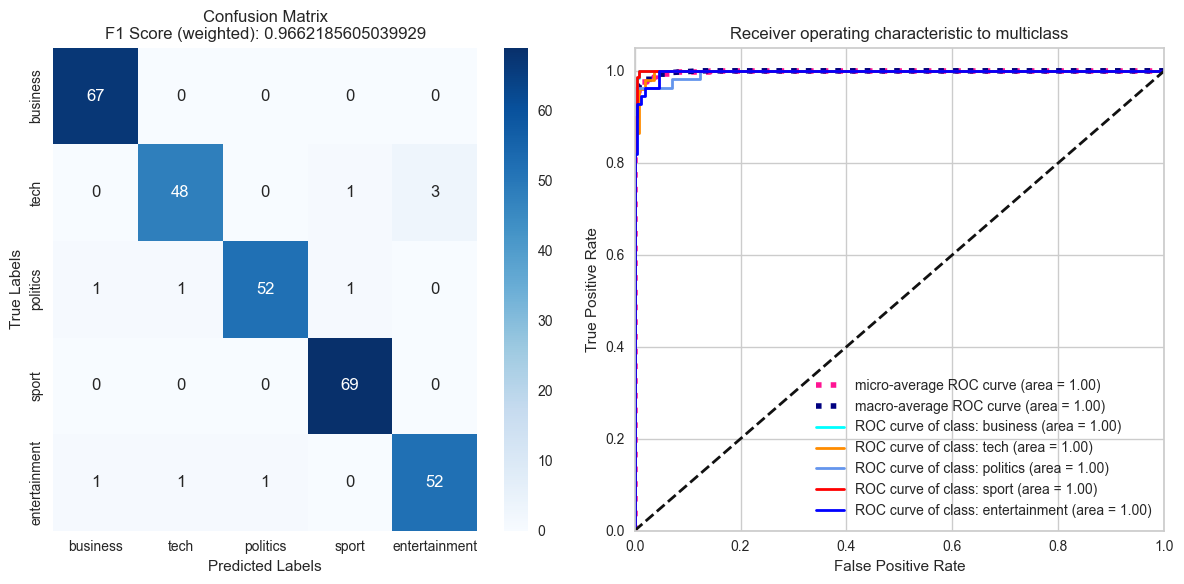

In [48]:
confusion_matrix_and_roc_curve_plot(y_test, y_pred_test, y_test_proba, label_dict)

### 4.2 SVM on One Hot

In [50]:
model_name = "Support Vector Classifier"
model_save_name = "support_vector_model"

# Start MLflow run
with mlflow.start_run(run_name=f"One Hot Enbedding + {model_name}"):

    # initializing model
    classifier = SVC(probability=True)
    # Train the model
    classifier.fit(X_train, y_train)

    # Predict
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    y_test_proba = classifier.predict_proba(X_test)

    # Evaluate the model
    f1_score_train = f1_score(y_train, y_pred_train, average='micro')
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)

    # Log parameters (e.g., model hyperparameters)
    mlflow.log_param("model", f"{model_name}")

    # Log metrics (e.g., f1 score, precision, recall, F1-score)
    mlflow.log_metric("train f1 score", f1_score_train)
    for label, metrics in train_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    mlflow.log_metric("test f1 score", f1_score_test)
    for label, metrics in test_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Log the trained model
    mlflow.sklearn.log_model(classifier, model_save_name, input_example=X_train[0].reshape(1, -1))

    # End the MLflow run (automatically done when exiting the context)
    # print(f"Model trained and logged with run ID: {mlflow.active_run().info.run_id}")

    print(f"Logged {model_name} model with training f1 score: {f1_score_train}")
    print(f"Logged {model_name} model with testing f1 score: {f1_score_test}")

Logged Support Vector Classifier model with training f1 score: 1.0
Logged Support Vector Classifier model with testing f1 score: 0.9664429530201343


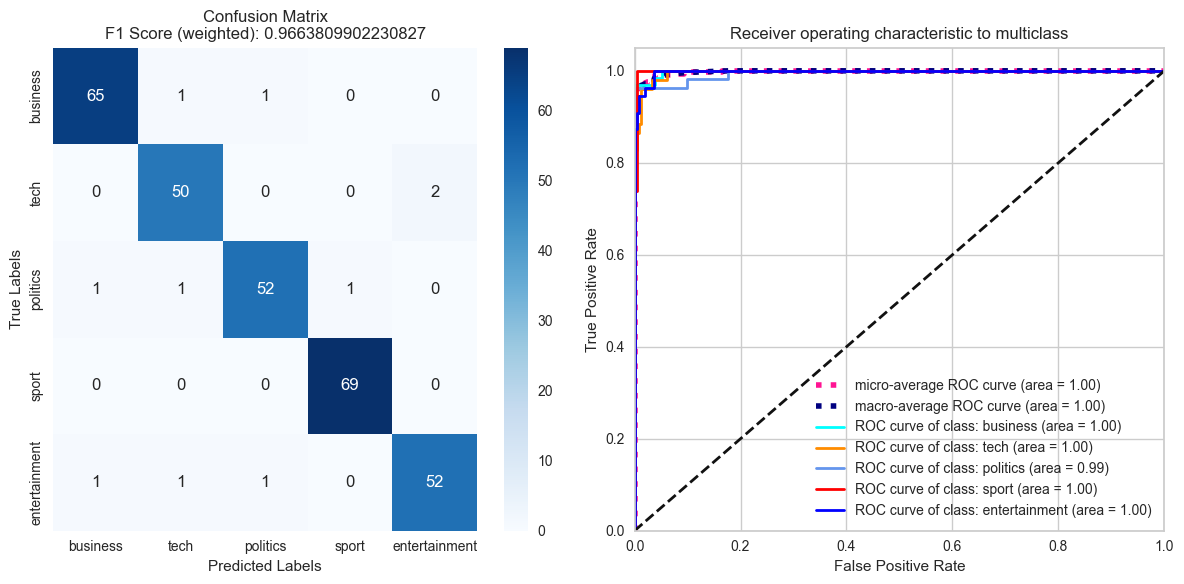

In [51]:
confusion_matrix_and_roc_curve_plot(y_test, y_pred_test, y_test_proba, label_dict)

### 4.3 Random Forest on One Hot

In [52]:
model_name = "Random Forest Classifier"
model_save_name = "random_forest_model"

# Start MLflow run
with mlflow.start_run(run_name=f"One Hot Enbedding + {model_name}"):

    # initializing model
    classifier = RandomForestClassifier()
    # Train the model
    classifier.fit(X_train, y_train)

    # Predict
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    y_test_proba = classifier.predict_proba(X_test)

    # Evaluate the model
    f1_score_train = f1_score(y_train, y_pred_train, average='micro')
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)

    # Log parameters (e.g., model hyperparameters)
    mlflow.log_param("model", f"{model_name}")

    # Log metrics (e.g., f1 score, precision, recall, F1-score)
    mlflow.log_metric("train f1 score", f1_score_train)
    for label, metrics in train_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    mlflow.log_metric("test f1 score", f1_score_test)
    for label, metrics in test_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Log the trained model
    mlflow.sklearn.log_model(classifier, model_save_name, input_example=X_train[0].reshape(1, -1))

    # End the MLflow run (automatically done when exiting the context)
    # print(f"Model trained and logged with run ID: {mlflow.active_run().info.run_id}")

    print(f"Logged {model_name} model with training f1 score: {f1_score_train}")
    print(f"Logged {model_name} model with testing f1 score: {f1_score_test}")

Logged Random Forest Classifier model with training f1 score: 1.0
Logged Random Forest Classifier model with testing f1 score: 0.9496644295302014


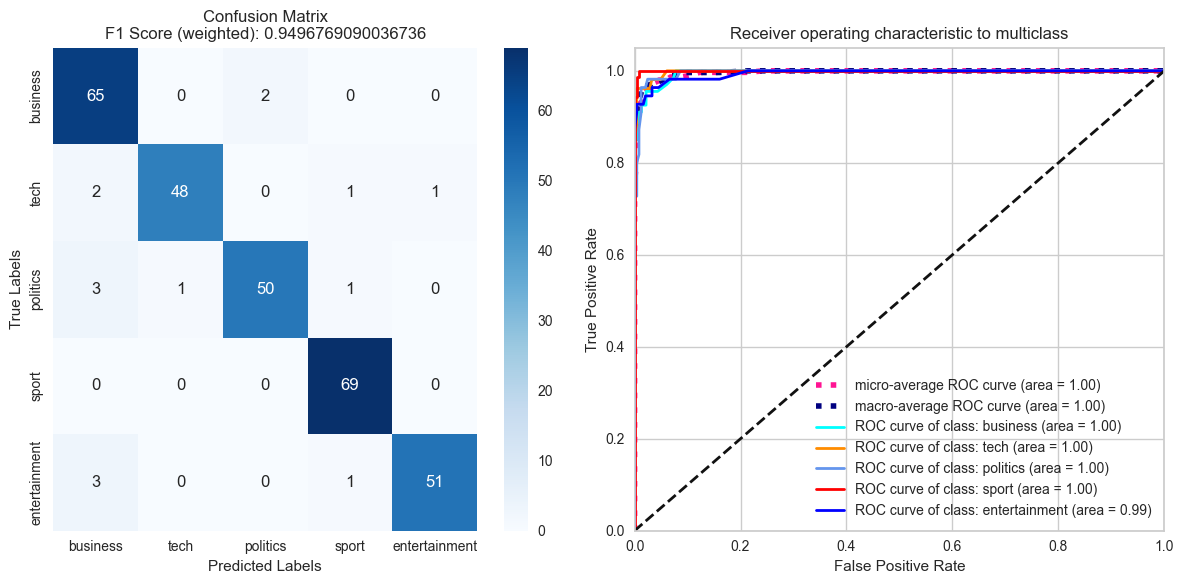

In [53]:
confusion_matrix_and_roc_curve_plot(y_test, y_pred_test, y_test_proba, label_dict)

### 4.4 Gradient Boosting on One Hot

In [54]:
model_name = "Gradient Boosting Classifier"
model_save_name = "gradient_boosting_model"

# Start MLflow run
with mlflow.start_run(run_name=f"One Hot Enbedding + {model_name}"):

    # initializing model
    classifier = GradientBoostingClassifier(verbose=False)
    # Train the model
    classifier.fit(X_train, y_train)

    # Predict
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    y_test_proba = classifier.predict_proba(X_test)

    # Evaluate the model
    f1_score_train = f1_score(y_train, y_pred_train, average='micro')
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)

    # Log parameters (e.g., model hyperparameters)
    mlflow.log_param("model", f"{model_name}")

    # Log metrics (e.g., f1 score, precision, recall, F1-score)
    mlflow.log_metric("train f1 score", f1_score_train)
    for label, metrics in train_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    mlflow.log_metric("test f1 score", f1_score_test)
    for label, metrics in test_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Log the trained model
    mlflow.sklearn.log_model(classifier, model_save_name, input_example=X_train[0].reshape(1, -1))

    # End the MLflow run (automatically done when exiting the context)
    # print(f"Model trained and logged with run ID: {mlflow.active_run().info.run_id}")

    print(f"Logged {model_name} model with training f1 score: {f1_score_train}")
    print(f"Logged {model_name} model with testing f1 score: {f1_score_test}")

Logged Gradient Boosting Classifier model with training f1 score: 1.0
Logged Gradient Boosting Classifier model with testing f1 score: 0.9261744966442953


In [ ]:
confusion_matrix_and_roc_curve_plot(y_test, y_pred_test, y_test_proba, label_dict)

## 5. TF-IDF Encoding

In [56]:
# Features and target
X = train_df['Clean_text']
y = train_df['Label']

In [57]:
# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,              # 20% test set
    random_state=42,            # for reproducibility
    stratify=y                  # preserve class distribution
)

In [58]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(X_train)

tfidf_matrix = np.asarray(tfidf_matrix.toarray())

# Get the feature names (i.e., terms in the vocabulary)
train_feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a dense format (for better visualization)
X_train_dense_matrix = tfidf_matrix#.todense()

In [60]:
# Fit and transform the documents
tfidf_matrix = vectorizer.transform(X_test)

tfidf_matrix = np.asarray(tfidf_matrix.toarray())

# Get the feature names (i.e., terms in the vocabulary)
train_feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a dense format (for better visualization)
X_test_dense_matrix = tfidf_matrix#.todense()

In [61]:
X_train_dense_matrix.shape, X_test_dense_matrix.shape

((1192, 17645), (298, 17645))

In [62]:
X_train_dense_matrix.shape, y_train.shape, X_test_dense_matrix.shape, y_test.shape

((1192, 17645), (1192,), (298, 17645), (298,))

In [63]:
X_train = X_train_dense_matrix
X_test = X_test_dense_matrix

### Model Training

### 5.1 Logistic Regression on TF-IDF

In [64]:
# Start an experiment (if not already created)
mlflow.set_experiment("TF_IDF_Embeddings")

model_name = "Logistic Regression"
model_save_name = "logistic_regression_model"

# Start MLflow run
with mlflow.start_run(run_name=f"TF-IDF Enbedding + {model_name}"):

    # initializing model
    classifier = LogisticRegression(max_iter=1000)
    # Train the model
    classifier.fit(X_train, y_train)

    # Predict
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    y_test_proba = classifier.predict_proba(X_test)

    # Evaluate the model
    f1_score_train = f1_score(y_train, y_pred_train, average='micro')
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)

    # Log parameters (e.g., model hyperparameters)
    mlflow.log_param("model", f"{model_name}")

    # Log metrics (e.g., f1 score, precision, recall, F1-score)
    mlflow.log_metric("train f1 score", f1_score_train)
    for label, metrics in train_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    mlflow.log_metric("test f1 score", f1_score_test)
    for label, metrics in test_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Log the trained model
    mlflow.sklearn.log_model(classifier, model_save_name, input_example=X_train[0].reshape(1, -1))

    # End the MLflow run (automatically done when exiting the context)
    # print(f"Model trained and logged with run ID: {mlflow.active_run().info.run_id}")

    print(f"Logged {model_name} model with training f1 score: {f1_score_train}")
    print(f"Logged {model_name} model with testing f1 score: {f1_score_test}")


2025/07/12 21:46:05 INFO mlflow.tracking.fluent: Experiment with name 'TF_IDF_Embeddings' does not exist. Creating a new experiment.


Logged Logistic Regression model with training f1 score: 0.9983221476510067
Logged Logistic Regression model with testing f1 score: 0.9530201342281879


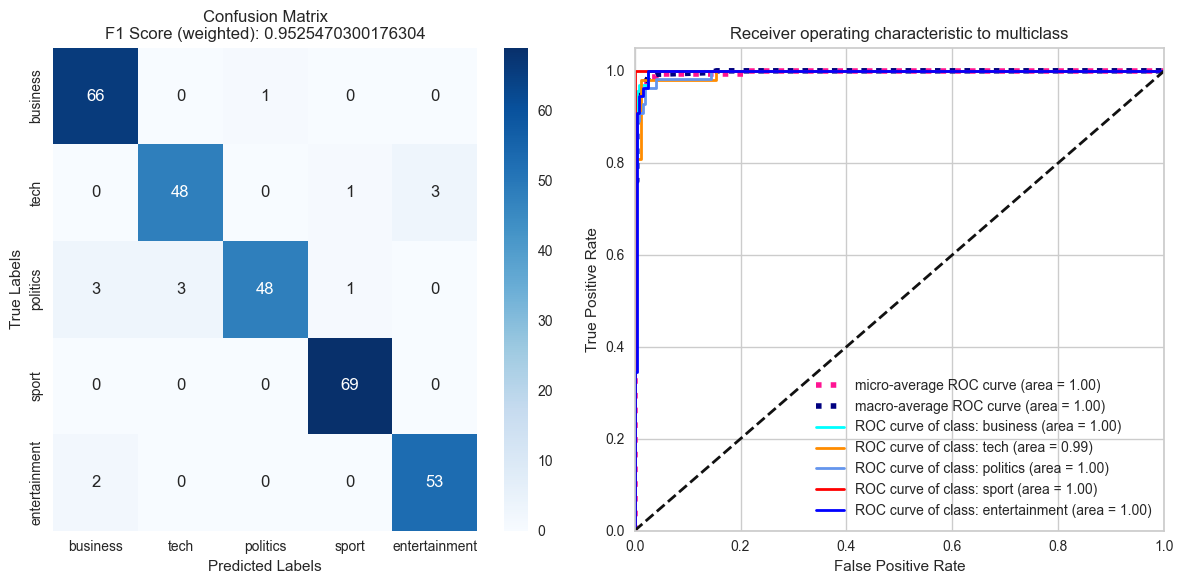

In [65]:
confusion_matrix_and_roc_curve_plot(y_test, y_pred_test, y_test_proba, label_dict)

### 5.2 SVM on TF-IDF

In [68]:
model_name = "Support Vector Classifier"
model_save_name = "support_vector_model"

# Start MLflow run
with mlflow.start_run(run_name=f"TF-IDF Enbedding + {model_name}"):

    # initializing model
    classifier = SVC(probability=True)
    # Train the model
    classifier.fit(X_train, y_train)

    # Predict
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    y_test_proba = classifier.predict_proba(X_test)

    # Evaluate the model
    f1_score_train = f1_score(y_train, y_pred_train, average='micro')
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)

    # Log parameters (e.g., model hyperparameters)
    mlflow.log_param("model", f"{model_name}")

    # Log metrics (e.g., f1 score, precision, recall, F1-score)
    mlflow.log_metric("train f1 score", f1_score_train)
    for label, metrics in train_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    mlflow.log_metric("test f1 score", f1_score_test)
    for label, metrics in test_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Log the trained model
    mlflow.sklearn.log_model(classifier, model_save_name, input_example=X_train[0].reshape(1, -1))

    # End the MLflow run (automatically done when exiting the context)
    # print(f"Model trained and logged with run ID: {mlflow.active_run().info.run_id}")

    print(f"Logged {model_name} model with training f1 score: {f1_score_train}")
    print(f"Logged {model_name} model with testing f1 score: {f1_score_test}")

Logged Support Vector Classifier model with training f1 score: 1.0
Logged Support Vector Classifier model with testing f1 score: 0.9496644295302014


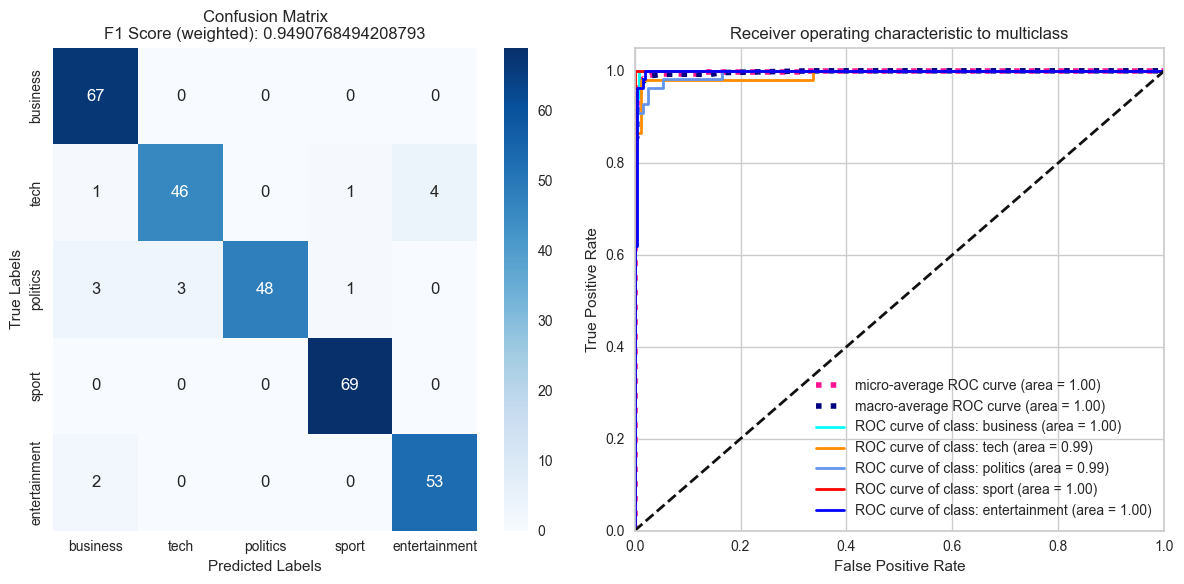

In [69]:
confusion_matrix_and_roc_curve_plot(y_test, y_pred_test, y_test_proba, label_dict)

### 5.3 Random Forest on TF-IDF

In [70]:
model_name = "Random Forest Classifier"
model_save_name = "random_forest_model"

# Start MLflow run
with mlflow.start_run(run_name=f"TF-IDF Enbedding + {model_name}"):

    # initializing model
    classifier = RandomForestClassifier()
    # Train the model
    classifier.fit(X_train, y_train)

    # Predict
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    y_test_proba = classifier.predict_proba(X_test)

    # Evaluate the model
    f1_score_train = f1_score(y_train, y_pred_train, average='micro')
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)

    # Log parameters (e.g., model hyperparameters)
    mlflow.log_param("model", f"{model_name}")

    # Log metrics (e.g., f1 score, precision, recall, F1-score)
    mlflow.log_metric("train f1 score", f1_score_train)
    for label, metrics in train_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    mlflow.log_metric("test f1 score", f1_score_test)
    for label, metrics in test_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Log the trained model
    mlflow.sklearn.log_model(classifier, model_save_name, input_example=X_train[0].reshape(1, -1))

    # End the MLflow run (automatically done when exiting the context)
    # print(f"Model trained and logged with run ID: {mlflow.active_run().info.run_id}")

    print(f"Logged {model_name} model with training f1 score: {f1_score_train}")
    print(f"Logged {model_name} model with testing f1 score: {f1_score_test}")

Logged Random Forest Classifier model with training f1 score: 1.0
Logged Random Forest Classifier model with testing f1 score: 0.9429530201342282


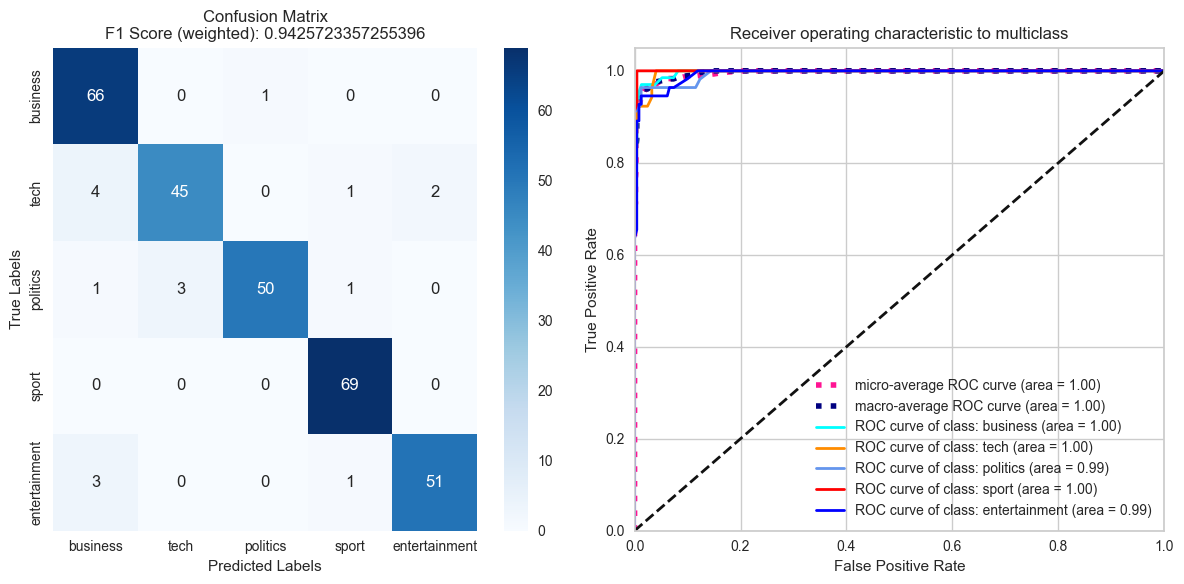

In [71]:
confusion_matrix_and_roc_curve_plot(y_test, y_pred_test, y_test_proba, label_dict)

### 5.4 Gradient Boosting on TF-IDF

In [72]:
model_name = "Gradient Boosting Classifier"
model_save_name = "gradient_boosting_model"

# Start MLflow run
with mlflow.start_run(run_name=f"TF-IDF Enbedding + {model_name}"):

    # initializing model
    classifier = GradientBoostingClassifier(verbose=False)
    # Train the model
    classifier.fit(X_train, y_train)

    # Predict
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    y_test_proba = classifier.predict_proba(X_test)

    # Evaluate the model
    f1_score_train = f1_score(y_train, y_pred_train, average='micro')
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)

    # Log parameters (e.g., model hyperparameters)
    mlflow.log_param("model", f"{model_name}")

    # Log metrics (e.g., f1 score, precision, recall, F1-score)
    mlflow.log_metric("train f1 score", f1_score_train)
    for label, metrics in train_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    mlflow.log_metric("test f1 score", f1_score_test)
    for label, metrics in test_report.items():
        if isinstance(metrics, dict):  # Only log metrics that are numeric (e.g., per-class metrics)
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Log the trained model
    mlflow.sklearn.log_model(classifier, model_save_name, input_example=X_train[0].reshape(1, -1))

    # End the MLflow run (automatically done when exiting the context)
    # print(f"Model trained and logged with run ID: {mlflow.active_run().info.run_id}")

    print(f"Logged {model_name} model with training f1 score: {f1_score_train}")
    print(f"Logged {model_name} model with testing f1 score: {f1_score_test}")

Logged Gradient Boosting Classifier model with training f1 score: 1.0
Logged Gradient Boosting Classifier model with testing f1 score: 0.9362416107382551


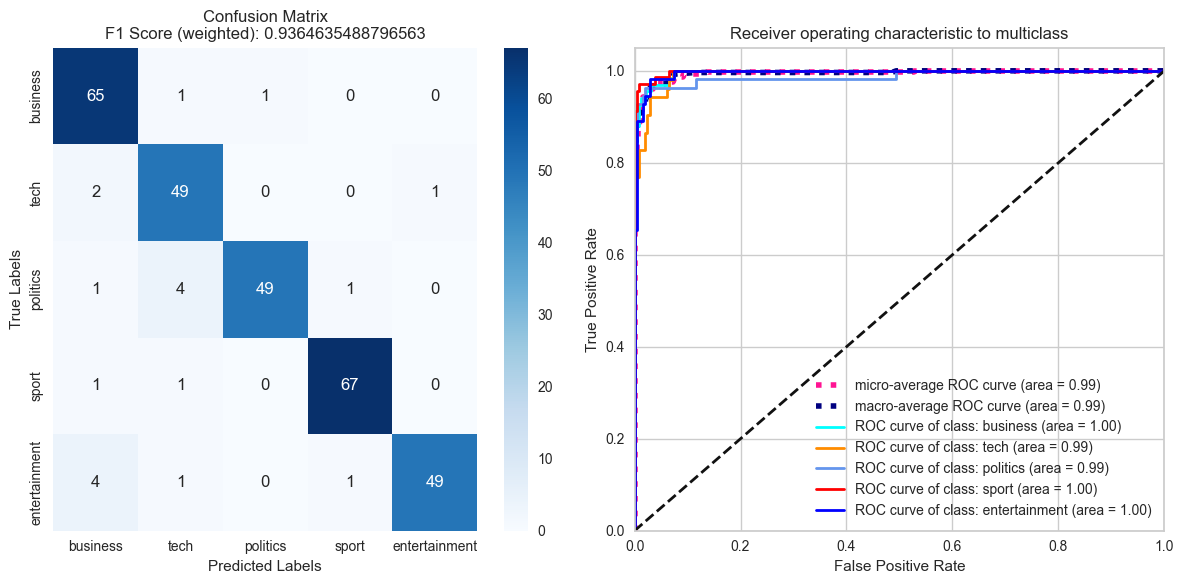

In [73]:
confusion_matrix_and_roc_curve_plot(y_test, y_pred_test, y_test_proba, label_dict)

## Results Summary

In [74]:
#@title
myTable = PrettyTable(["Baseline Model (F1 Score)", "One-Hot", "TF-IDF"])

# Logistic Regression
myTable.add_row(["Logistic Regression", 0.9664, 0.9530])

# SVC
myTable.add_row(["SVC", 0.9664, 0.9496])

# Random Forest
myTable.add_row(["Random Forest", 0.9496, 0.9429])

# Gradient Boost
myTable.add_row(["Gradient Boost", 0.9261, 0.9362])

print(myTable)

+---------------------------+---------+--------+
| Baseline Model (F1 Score) | One-Hot | TF-IDF |
+---------------------------+---------+--------+
|    Logistic Regression    |  0.9664 | 0.953  |
|            SVC            |  0.9664 | 0.9496 |
|       Random Forest       |  0.9496 | 0.9429 |
|       Gradient Boost      |  0.9261 | 0.9362 |
+---------------------------+---------+--------+
